In [1]:
import os
import random
from io import StringIO

import arviz as az
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from lifelines import KaplanMeierFitter, LogNormalFitter, WeibullFitter
from lifelines.utils import survival_table_from_events
from scipy.stats import binom, lognorm, norm, weibull_min
import seaborn as sns
import json
import time

In [2]:

y = np.array([56]*3000 + [117]*1500 + [266]*1250 + [315]*1150 + [405]*1100 + [501]*1000 +
                 [615]*1100 + [704]*1150 + [838]*120 + [901]*130 + [1010]*125 + [1111]*100 +
                 [1250]*50 + [1350]*400 + [1500]*300 + [1600]*100 + [1700]*5 + [1870]*3 +
                 [2070]*4 + [1550]*1 + [1050]*1 + [1000]*1 + [500]*1 + [350]*1 + [250]*1)

censored = np.array([True]*3000 + [True]*1500 + [True]*1250+ [True]*1150 + [True]*1100 + [True]*1000 +
                 [True]*1100 + [True]*1150 + [True]*120 + [True]*130 + [True]*125 + [True]*100 +
                 [True]*50 + [True]*400 + [True]*300 + [True]*100 + [True]*5 + [True]*3 +
                 [True]*4 + [False]*1 + [False]*1 + [False]*1 + [False]*1 + [False]*1 + [False]*1)




def weibull_lccdf(y, alpha, beta):
    """Log complementary cdf of Weibull distribution."""
    return -((y / beta) ** alpha)

#beta = Shape parameter
#alpha = Scale parameter

priors = {"beta": [100, 15000], "alpha": [4, 1, 0.02, 8]}
priors_informative = {"beta": [10000, 500], "alpha": [2, 0.5, 0.02, 3]}

def dict_master(Sampler_name, idata,timer_s,dict_data):
  
    
    summary=az.summary(idata,kind='all')
    
    summary_dict=pd.DataFrame.to_dict(summary,orient="dict")
    dict_data.update({Sampler_name:summary_dict})   
    summary_dict.update({"Computation time(sec)":timer_s})

    dict_data.update(dict_data)
    
    
    dict_update=dict_data

    with open("ece620_1kFixed.json", "w") as outfile:
        json.dump(dict_update,outfile,indent=4)

    return dict_update



def make_model(p, alg, info=False):
    with pm.Model() as model:
        if info:
            beta = pm.Normal("beta", p["beta"][0], p["beta"][1])
        else:
            beta = pm.Uniform("beta", p["beta"][0], p["beta"][1])
        alpha = pm.TruncatedNormal(
            "alpha", p["alpha"][0], p["alpha"][1], lower=p["alpha"][2], upper=p["alpha"][3]
        )
        
        
        y_obs = pm.Weibull("y_obs", alpha=alpha, beta=beta, observed=y[~censored])
        y_cens = pm.Potential("y_cens", weibull_lccdf(y[censored], alpha, beta))
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(draws=1000,tune=1000, cores=32,step=alg()))
        idata.extend(pm.sample_posterior_predictive(idata))

    return idata, model
dict_data={}

start_time_ns = time.time_ns()
idataN, modelN = make_model(priors,pm.NUTS)
end_time_ns = time.time_ns()
timer_ns = end_time_ns - start_time_ns
timer_s=timer_ns/1000000000
print(timer_s,'seconds')

dict_data = dict_master("NUTS",idataN,timer_s,dict_data)


start_time_ns = time.time_ns()
idataM, modelM = make_model(priors,pm.Metropolis)
end_time_ns = time.time_ns()
timer_ns = end_time_ns - start_time_ns
timer_s=timer_ns/1000000000
print(timer_s,'seconds')

dict_data = dict_master("Metropolis",idataM,timer_s,dict_data)

start_time_ns = time.time_ns()
idataDEM, modelDEM = make_model(priors,pm.DEMetropolis)
end_time_ns = time.time_ns()
timer_ns = end_time_ns - start_time_ns
timer_s=timer_ns/1000000000
print(timer_s,'seconds')

dict_data = dict_master("DEMetropolis",idataDEM,timer_s,dict_data)

start_time_ns = time.time_ns()
idataDEMZ, modelDEMZ = make_model(priors,pm.DEMetropolisZ)
end_time_ns = time.time_ns()
timer_ns = end_time_ns - start_time_ns
timer_s=timer_ns/1000000000
print(timer_s,'seconds')

dict_data = dict_master("DEMetropolisZ",idataDEM,timer_s,dict_data)

start_time_ns = time.time_ns()
idataS, modelS = make_model(priors,pm.Slice)
end_time_ns = time.time_ns()
timer_ns = end_time_ns - start_time_ns
timer_s=timer_ns/1000000000
print(timer_s,'seconds')

dict_data = dict_master("Slice",idataS,timer_s,dict_data)



/tmp/ipykernel_5062/694214291.py:58: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()
Sampling: [alpha, beta, y_obs]
Multiprocess sampling (32 chains in 32 jobs)
NUTS: [beta, alpha]


Sampling 32 chains for 1_000 tune and 1_000 draw iterations (32_000 + 32_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 385 divergences after tuning. Increase `target_accept` or reparameterize.
/tmp/ipykernel_5062/694214291.py:60: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))
Sampling: [y_obs]


/tmp/ipykernel_5062/694214291.py:58: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()
Sampling: [alpha, beta, y_obs]


38.498711522 seconds


Multiprocess sampling (32 chains in 32 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 32 chains for 1_000 tune and 1_000 draw iterations (32_000 + 32_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/tmp/ipykernel_5062/694214291.py:60: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))
Sampling: [y_obs]


/tmp/ipykernel_5062/694214291.py:58: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()
Sampling: [alpha, beta, y_obs]


23.234518881 seconds


Population sampling (32 chains)
DEMetropolis: [beta, alpha]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 32 chains for 1_000 tune and 1_000 draw iterations (32_000 + 32_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/tmp/ipykernel_5062/694214291.py:60: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))
Sampling: [y_obs]


/tmp/ipykernel_5062/694214291.py:58: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()
Sampling: [alpha, beta, y_obs]


30.480591855 seconds


Multiprocess sampling (32 chains in 32 jobs)
DEMetropolisZ: [beta, alpha]


Sampling 32 chains for 1_000 tune and 1_000 draw iterations (32_000 + 32_000 draws total) took 4 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/tmp/ipykernel_5062/694214291.py:60: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))
Sampling: [y_obs]


/tmp/ipykernel_5062/694214291.py:58: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()
Sampling: [alpha, beta, y_obs]


21.847461266 seconds


Multiprocess sampling (32 chains in 32 jobs)
CompoundStep
>Slice: [beta]
>Slice: [alpha]


Sampling 32 chains for 1_000 tune and 1_000 draw iterations (32_000 + 32_000 draws total) took 10 seconds.
/tmp/ipykernel_5062/694214291.py:60: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))
Sampling: [y_obs]


27.354420025 seconds


In [3]:
def plotposterior(idata,title):
    pm.plot_trace(idata)
    axes = plt.gcf().get_axes()
    
    ax=axes[0]
    ax1=axes[1]
    ax2=axes[2]
    ax3=axes[3]
    ax.set_title("beta")
    plt.sca(ax) 
    plt.ylabel("Frequency")
    plt.xlabel("Time")


    ax1.set_title("beta")
    plt.sca(ax1) 
    plt.ylabel("Sample Values")
    plt.xlabel("Iterations")
    
    ax2.set_title("alpha")
    plt.sca(ax2) 
    plt.ylabel("Sample Values")
    plt.xlabel("Time")
    
    ax3.set_title("alpha")
    plt.sca(ax3) 
    plt.ylabel("Sample Values")
    plt.xlabel("Iterations")
    
    
    plt.suptitle(title, fontsize=16, y=1)

    plt.subplots_adjust(hspace=1)

    
    
    plt.show()


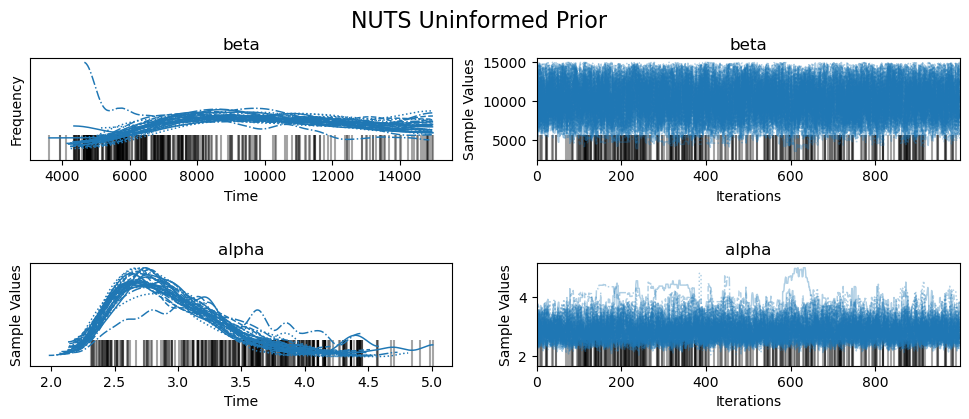

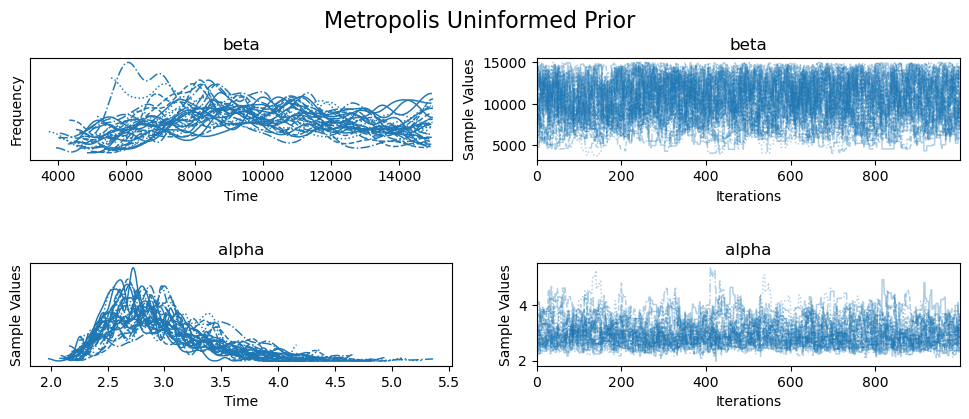

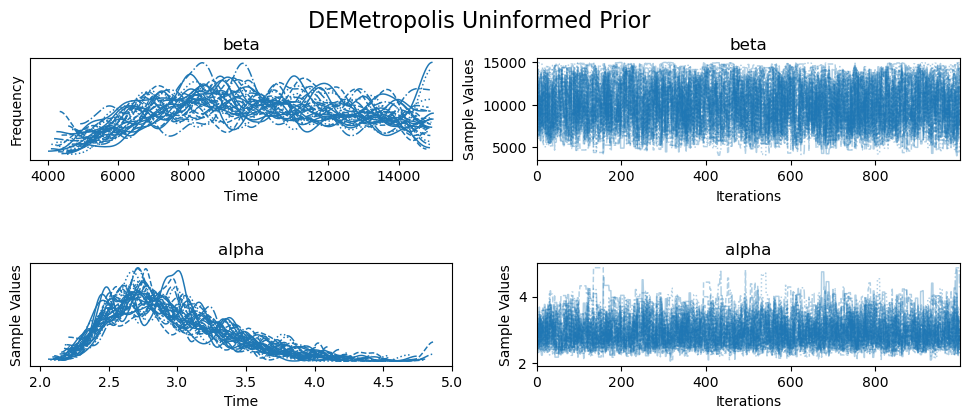

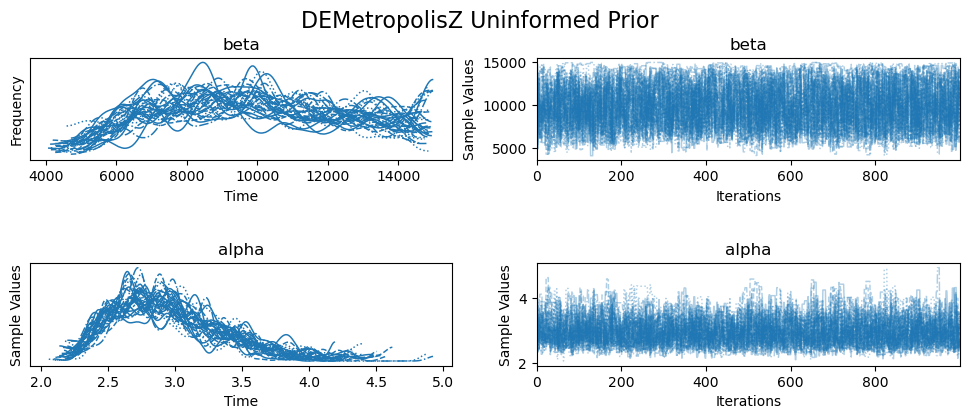

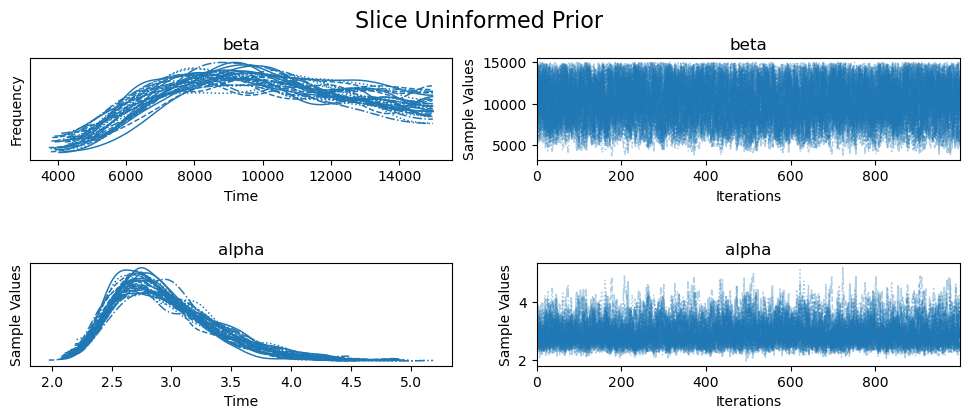

In [4]:
plotposterior(idataN,"NUTS Uninformed Prior")
plotposterior(idataM,"Metropolis Uninformed Prior")
plotposterior(idataDEM,"DEMetropolis Uninformed Prior")
plotposterior(idataDEMZ,"DEMetropolisZ Uninformed Prior")
plotposterior(idataS,"Slice Uninformed Prior")

In [5]:
start_time_ns = time.time_ns()
idata_informativeN, modelN = make_model(priors_informative,pm.NUTS, info=True)
end_time_ns = time.time_ns()
timer_ns = end_time_ns - start_time_ns
timer_s=timer_ns/1000000000
print(timer_s,'seconds')

dict_data = dict_master("NUTS Informed",idata_informativeN,timer_s,dict_data)


start_time_ns = time.time_ns()
idata_informativeM, modelM = make_model(priors_informative,pm.Metropolis, info=True)
end_time_ns = time.time_ns()
timer_ns = end_time_ns - start_time_ns
timer_s=timer_ns/1000000000
print(timer_s,'seconds')

dict_data = dict_master("Metropolis Informed",idata_informativeM,timer_s,dict_data)

start_time_ns = time.time_ns()
idata_informativeDEM, modelDEM = make_model(priors_informative,pm.DEMetropolis, info=True)
end_time_ns = time.time_ns()
timer_ns = end_time_ns - start_time_ns
timer_s=timer_ns/1000000000
print(timer_s,'seconds')

dict_data = dict_master("DEMetropolis Informed",idata_informativeDEM,timer_s,dict_data)

start_time_ns = time.time_ns()
idata_informativeDEMZ, modelDEMZ = make_model(priors_informative,pm.DEMetropolisZ, info=True)
end_time_ns = time.time_ns()
timer_ns = end_time_ns - start_time_ns
timer_s=timer_ns/1000000000
print(timer_s,'seconds')

dict_data = dict_master("DEMetropolisZ Informed",idata_informativeDEMZ,timer_s,dict_data)

start_time_ns = time.time_ns()
idata_informativeS, modelS = make_model(priors_informative,pm.Slice, info=True)
end_time_ns = time.time_ns()
timer_ns = end_time_ns - start_time_ns
timer_s=timer_ns/1000000000
print(timer_s,'seconds')

dict_data = dict_master("Slice Informed",idata_informativeS,timer_s,dict_data)


/tmp/ipykernel_5062/694214291.py:58: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()
Sampling: [alpha, beta, y_obs]
Multiprocess sampling (32 chains in 32 jobs)
NUTS: [beta, alpha]


Sampling 32 chains for 1_000 tune and 1_000 draw iterations (32_000 + 32_000 draws total) took 19 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
/tmp/ipykernel_5062/694214291.py:60: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))
Sampling: [y_obs]


/tmp/ipykernel_5062/694214291.py:58: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()
Sampling: [alpha, beta, y_obs]


37.694212184 seconds


Multiprocess sampling (32 chains in 32 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 32 chains for 1_000 tune and 1_000 draw iterations (32_000 + 32_000 draws total) took 5 seconds.
/tmp/ipykernel_5062/694214291.py:60: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))
Sampling: [y_obs]


/tmp/ipykernel_5062/694214291.py:58: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()
Sampling: [alpha, beta, y_obs]


19.298441981 seconds


Population sampling (32 chains)
DEMetropolis: [beta, alpha]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 32 chains for 1_000 tune and 1_000 draw iterations (32_000 + 32_000 draws total) took 13 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/tmp/ipykernel_5062/694214291.py:60: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))
Sampling: [y_obs]


/tmp/ipykernel_5062/694214291.py:58: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()
Sampling: [alpha, beta, y_obs]


27.116680245 seconds


Multiprocess sampling (32 chains in 32 jobs)
DEMetropolisZ: [beta, alpha]


Sampling 32 chains for 1_000 tune and 1_000 draw iterations (32_000 + 32_000 draws total) took 4 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/tmp/ipykernel_5062/694214291.py:60: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))
Sampling: [y_obs]


/tmp/ipykernel_5062/694214291.py:58: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()
Sampling: [alpha, beta, y_obs]


18.227296142 seconds


Multiprocess sampling (32 chains in 32 jobs)
CompoundStep
>Slice: [beta]
>Slice: [alpha]


Sampling 32 chains for 1_000 tune and 1_000 draw iterations (32_000 + 32_000 draws total) took 12 seconds.
/tmp/ipykernel_5062/694214291.py:60: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))
Sampling: [y_obs]


25.89380443 seconds


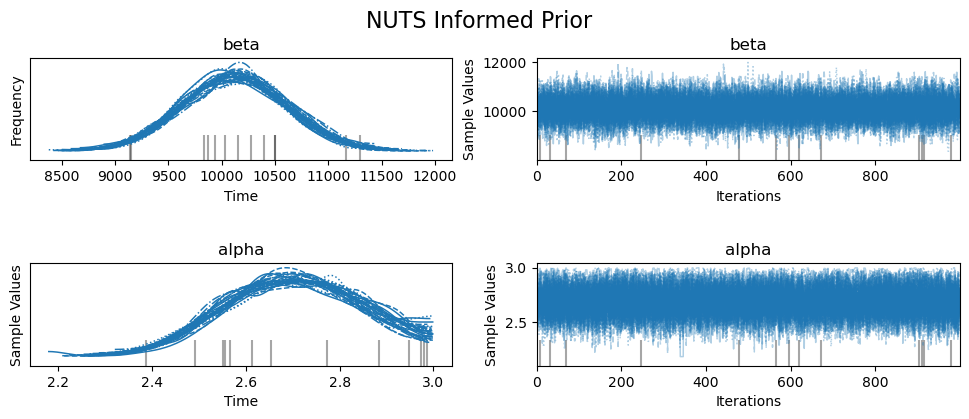

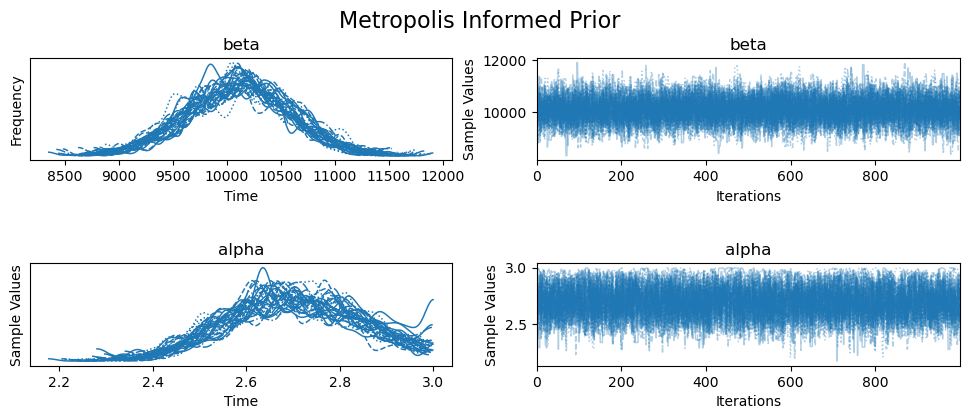

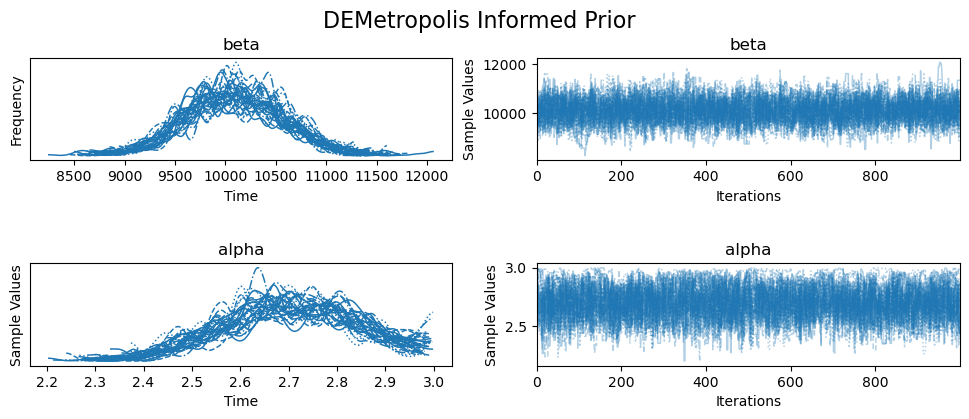

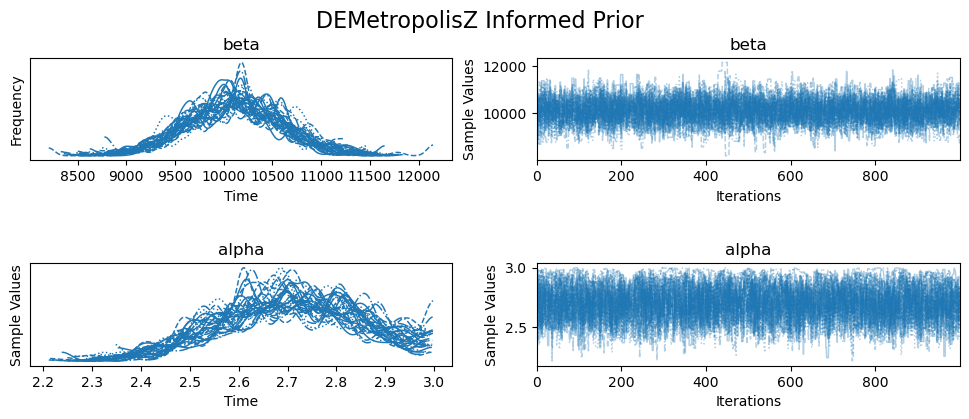

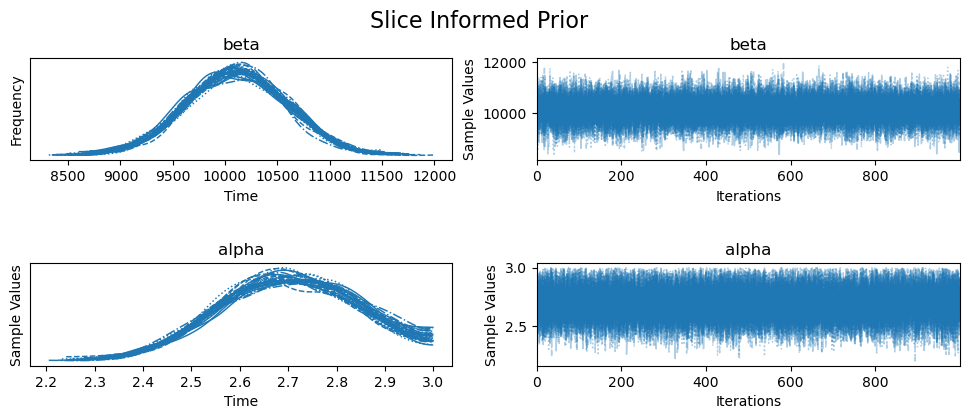

In [6]:
plotposterior(idata_informativeN,"NUTS Informed Prior")
plotposterior(idata_informativeM,"Metropolis Informed Prior")
plotposterior(idata_informativeDEM,"DEMetropolis Informed Prior")
plotposterior(idata_informativeDEMZ,"DEMetropolisZ Informed Prior")
plotposterior(idata_informativeS,"Slice Informed Prior")

In [7]:
def ecdf(sample):
    # convert sample to a numpy array, if it isn't already
    sample = np.atleast_1d(sample)

    # find the unique values and their corresponding counts
    quantiles, counts = np.unique(sample, return_counts=True)

    # take the cumulative sum of the counts and divide by the sample size to
    # get the cumulative probabilities between 0 and 1
    cumprob = np.cumsum(counts).astype(np.double) / sample.size

    return quantiles, cumprob

In [8]:
def plotpfailureandcdf(idata, idata_informative,title):
    joint_draws = az.extract(idata, num_samples=1000)[["alpha", "beta"]]
    alphas = joint_draws["alpha"].values
    betas = joint_draws["beta"].values

    joint_draws_informative = az.extract(idata_informative, num_samples=1000)[["alpha", "beta"]]
    alphas_informative = joint_draws_informative["alpha"].values
    betas_informative = joint_draws_informative["beta"].values

    draws = pm.draw(pm.Weibull.dist(alpha=np.mean(alphas), beta=np.mean(betas)), 1000)
    
    fig, ax = plt.subplots(figsize=(10, 8))

    hist_data = []
    for i in range(1000):
        draws = pm.draw(pm.Weibull.dist(alpha=alphas[i], beta=betas[i]), 1000)
        qe, pe = ecdf(draws)
        lkup = dict(zip(pe, qe))
        hist_data.append([lkup[0.1], lkup[0.05]])
        ax.plot(qe, pe, color="cyan", alpha=0.1)

    hist_data_info = []
    for i in range(1000):
        draws = pm.draw(pm.Weibull.dist(alpha=alphas_informative[i], beta=betas_informative[i]), 1000)
        qe, pe = ecdf(draws)
        lkup = dict(zip(pe, qe))
        hist_data_info.append([lkup[0.1], lkup[0.05]])
        ax.plot(qe, pe, color="pink", alpha=0.1)

    hist_data = pd.DataFrame(hist_data, columns=["p10", "p05"])
    hist_data_info = pd.DataFrame(hist_data_info, columns=["p10", "p05"])

    draws = pm.draw(pm.Weibull.dist(alpha=np.mean(alphas), beta=np.mean(betas)), 1000)
    qe, pe = ecdf(draws)
    ax.plot(qe, pe, color="blue", label="Expected CDF Uninformative Prior")

    draws = pm.draw(pm.Weibull.dist(alpha=np.mean(alphas_informative), beta=np.mean(betas_informative)), 1000)
    qe, pe = ecdf(draws)
    ax.plot(qe, pe, color="red", label="Expected CDF Informative Prior")

    ax.set_xlim(0, 30000)
    ax.set_title("Bayesian Estimation of Uncertainty in the Posterior Predictive CDF \n Informative and Non-Informative Priors", fontsize=20)
    ax.set_ylabel("Fraction Failing")
    ax.set_xlabel("Time")
    ax.legend()
    ax.set_ylim(0, 1);
    fig.suptitle(title, fontsize=24,y=1)
    
    
    fig, ax2 = plt.subplots(figsize=(10, 8))
    
    ax2.hist(hist_data["p05"], bins=30, ec="black", color="cyan", alpha=0.4, label="Uninformative Prior")
    ax2.hist(hist_data_info["p05"], bins=30, ec="black", color="red", alpha=0.4, label="Informative Prior")
    ax2.legend()
    ax2.set_title("Distribution of 5% failure Time", fontsize=20);
    fig.suptitle(title, fontsize=24,y=1)
    
    return joint_draws

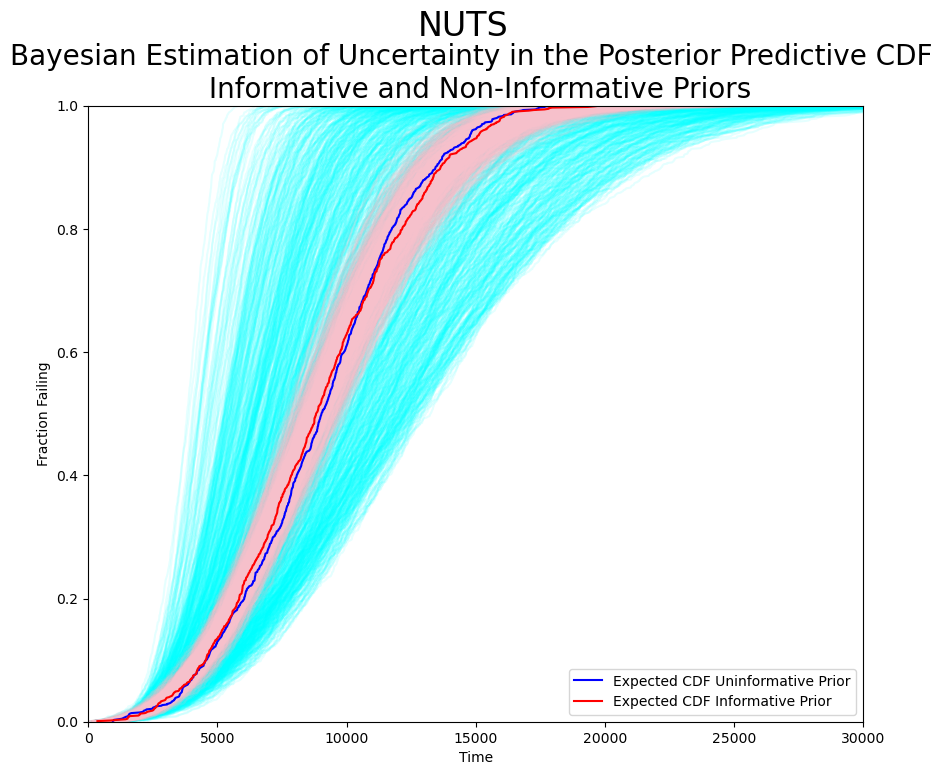

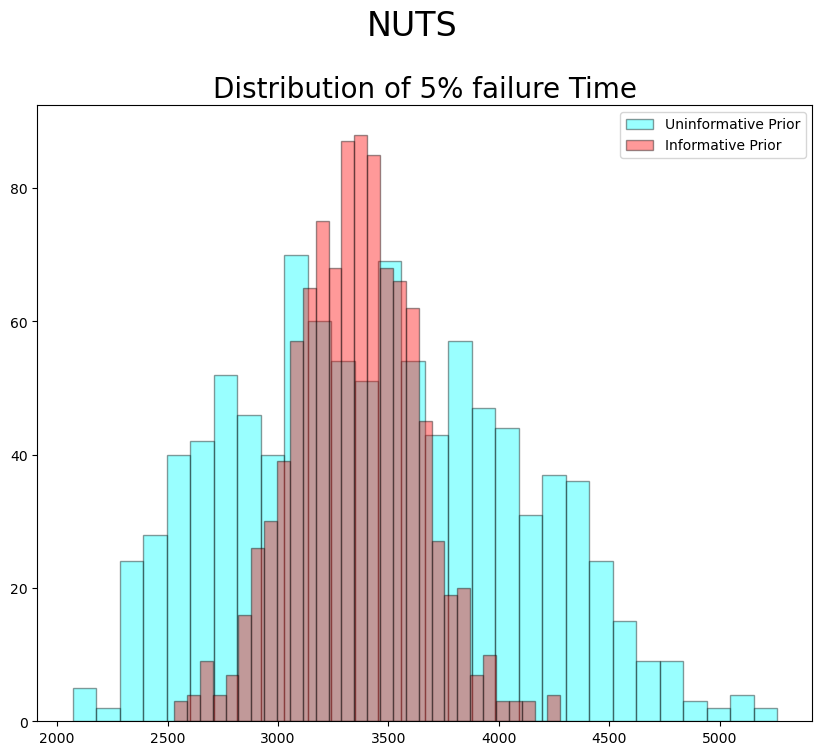

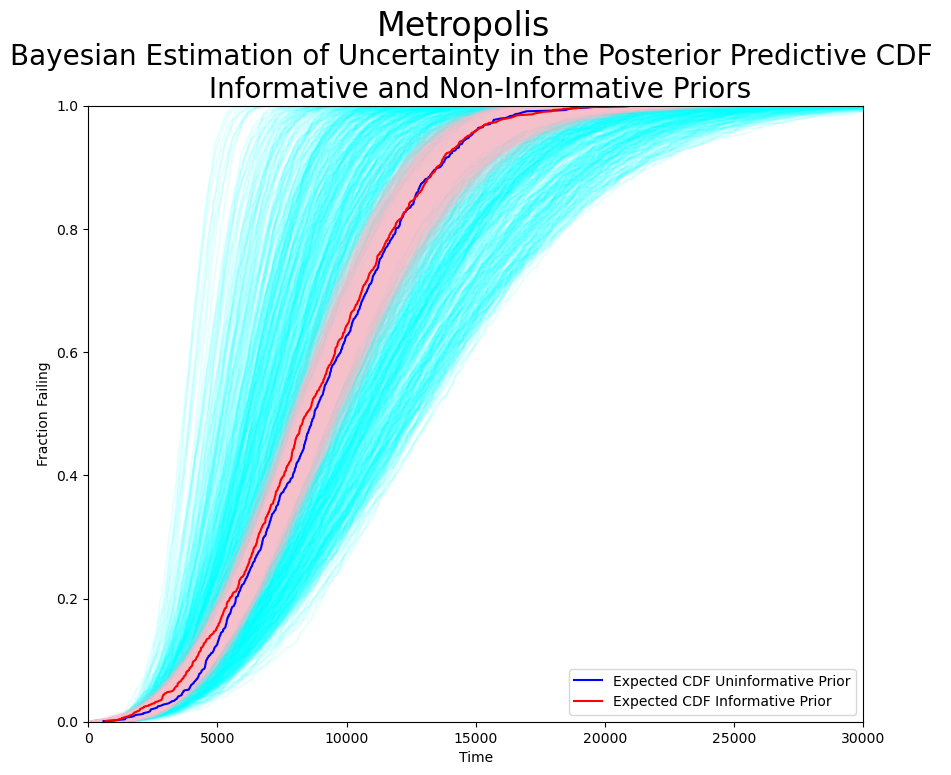

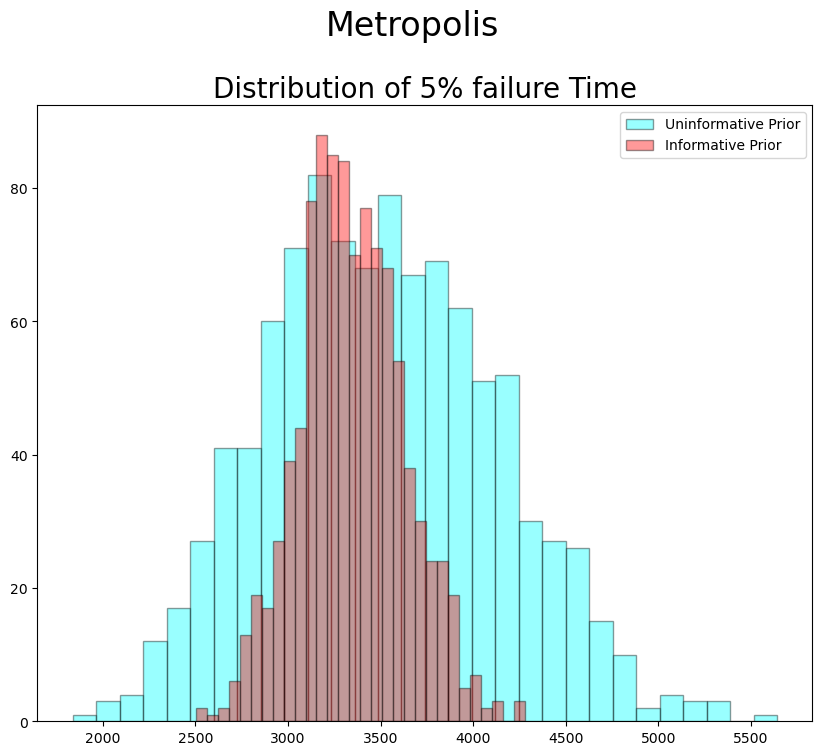

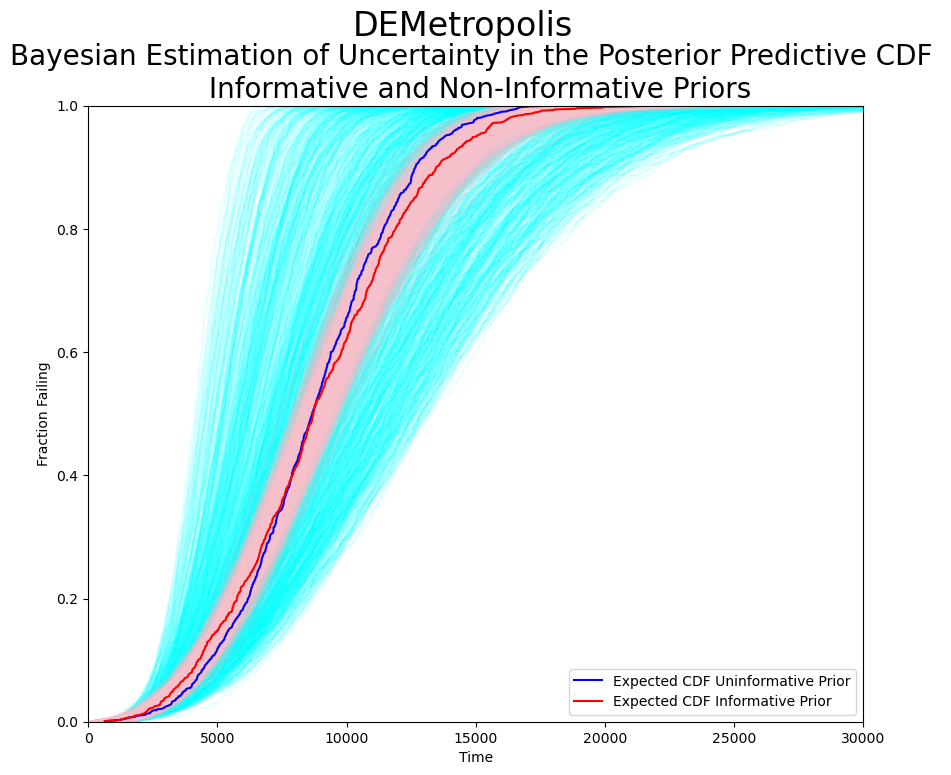

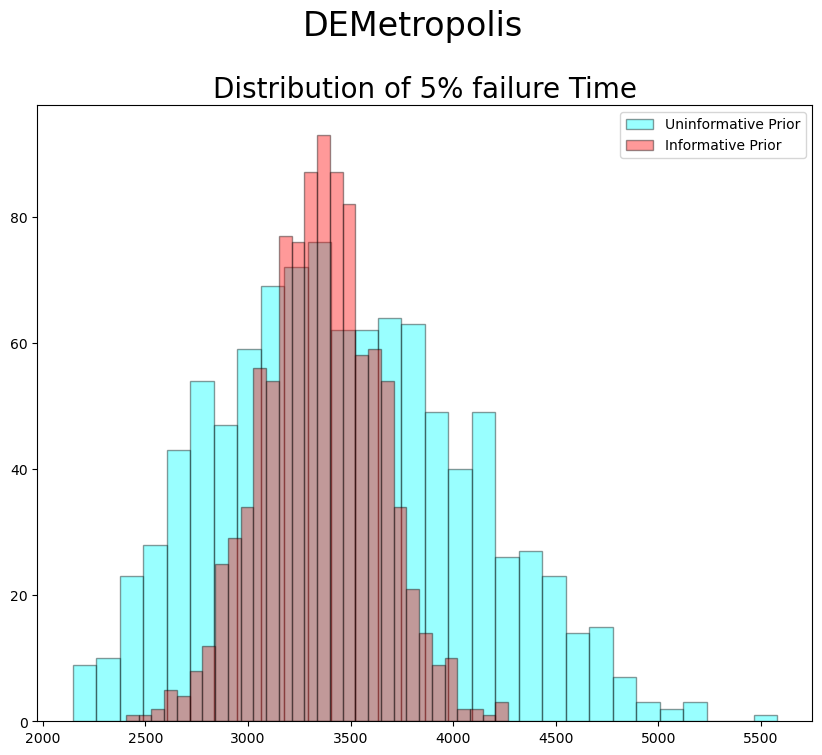

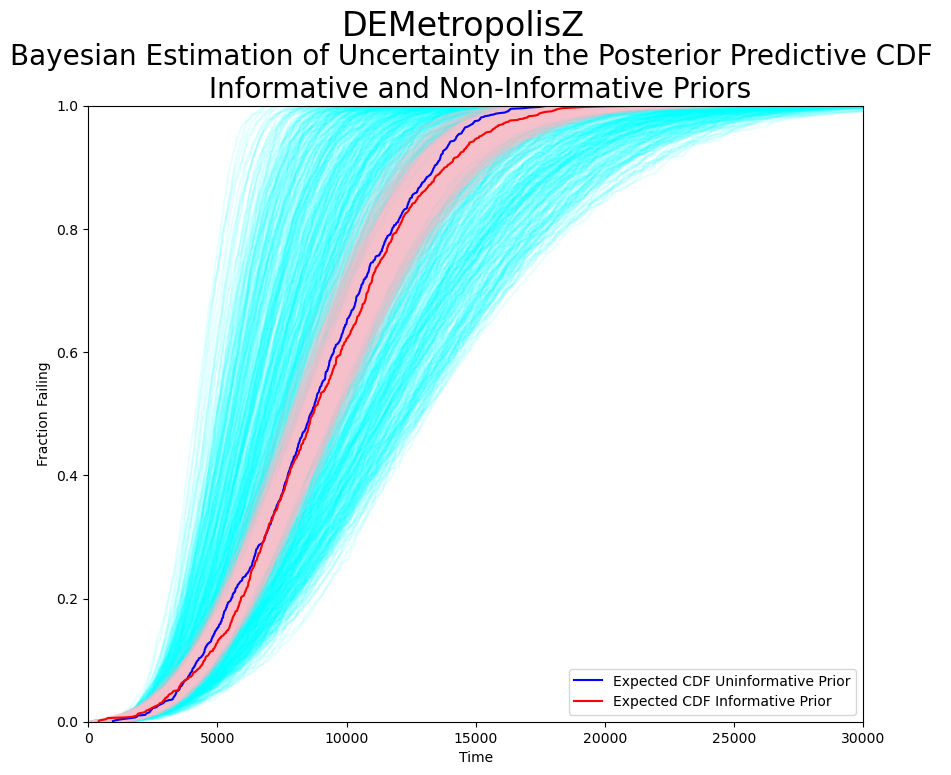

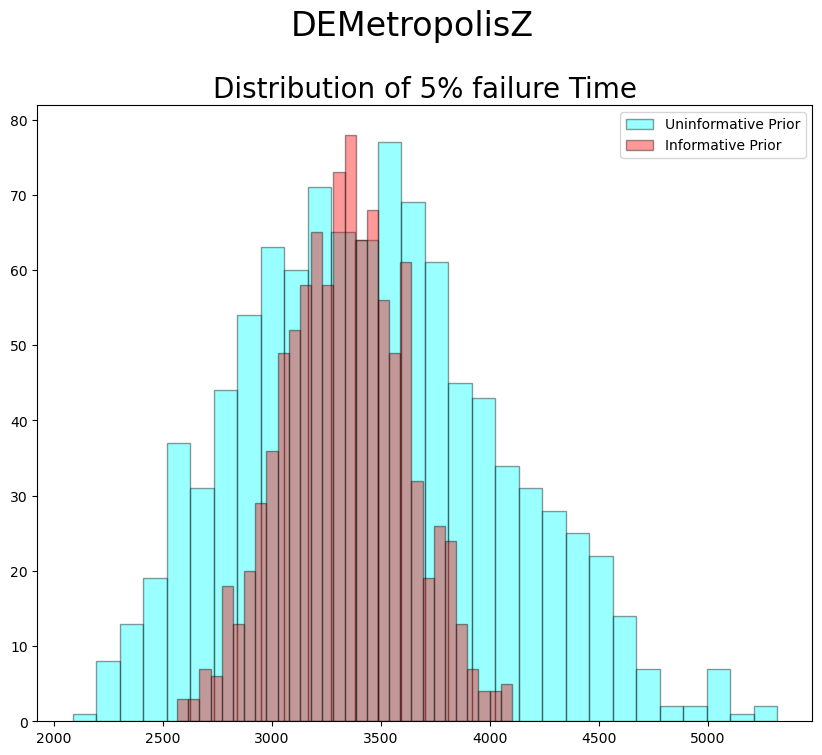

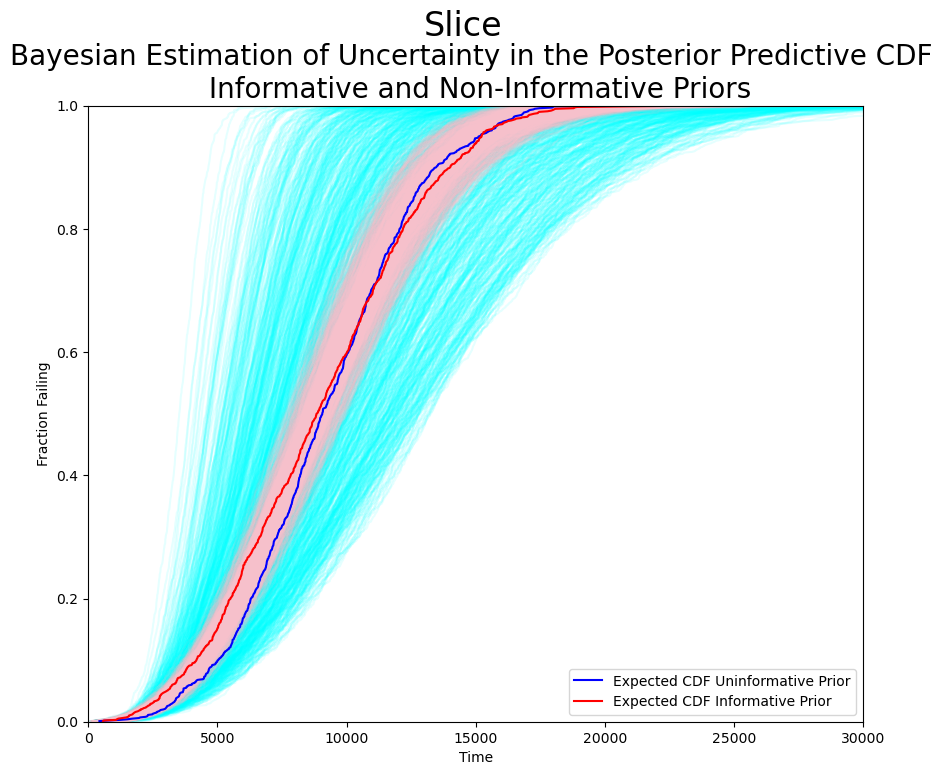

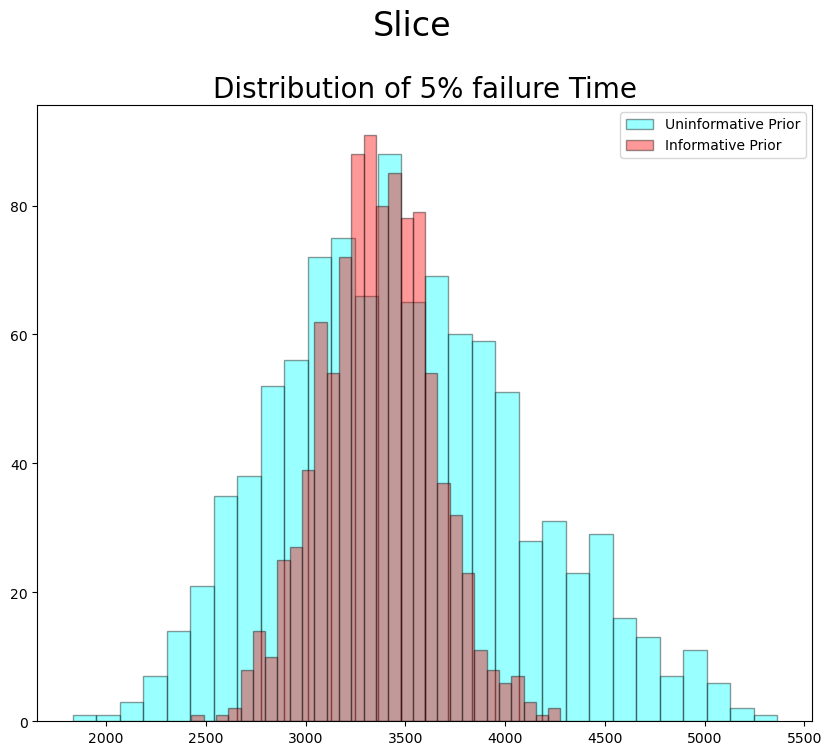

In [9]:
joint_drawsN = plotpfailureandcdf(idataN,idata_informativeN,"NUTS")
joint_drawsM = plotpfailureandcdf(idataM,idata_informativeM,"Metropolis")
joint_drawsDEM = plotpfailureandcdf(idataDEM,idata_informativeDEM,"DEMetropolis")
joint_drawsDEMZ = plotpfailureandcdf(idataDEMZ,idata_informativeDEMZ,"DEMetropolisZ")
joint_drawsS = plotpfailureandcdf(idataS,idata_informativeS,"Slice")

In [48]:
import xarray as xr

from xarray_einstats.stats import XrContinuousRV, XrDiscreteRV


def PI_failures(joint_draws, lp, up, n_at_risk):
    fit = XrContinuousRV(weibull_min, joint_draws["alpha"], scale=joint_draws["beta"])
    rho = fit.cdf(up) - fit.cdf(lp) / (1 - fit.cdf(lp))
    lub = XrDiscreteRV(binom, n_at_risk, rho).ppf([0.05, 0.95])
    lb, ub = lub.sel(quantile=0.05, drop=True), lub.sel(quantile=0.95, drop=True)
    point_prediction = n_at_risk * rho
    return xr.Dataset(
        {"rho": rho, "n_at_risk": n_at_risk, "lb": lb, "ub": ub, "expected": point_prediction}
    )


output_dsN = PI_failures(joint_drawsN, 100, 1000, 2000)
output_dsM = PI_failures(joint_drawsM, 100, 1000, 2000)
output_dsDEM = PI_failures(joint_drawsDEM, 100, 1000, 2000)
output_dsDEMZ = PI_failures(joint_drawsDEMZ, 100, 1000, 2000)
output_dsS = PI_failures(joint_drawsS, 100, 1000, 2000)

In [49]:
def cost_func(failures, power):
    #Imagined cost function for failing item e.g. refunds required
    return np.power(failures, power)

In [50]:
def failfuncofweibull(joint_draws,output_ds,title):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(
        joint_draws["alpha"],
        output_ds["expected"],
        c=joint_draws["beta"],
        cmap=cm.winter,
        alpha=0.3,
        label="Coloured by function of Beta values",
    )
    ax.legend()
    ax.set_ylabel("Expected Failures")
    ax.set_xlabel("Alpha")
    ax.set_title(
        "Posterior Predictive Expected Failure Count between 100-1000 hours \nas a function of Weibull(alpha, beta)",
        fontsize=20,
    );
    fig.suptitle(title, fontsize=24,y=1)

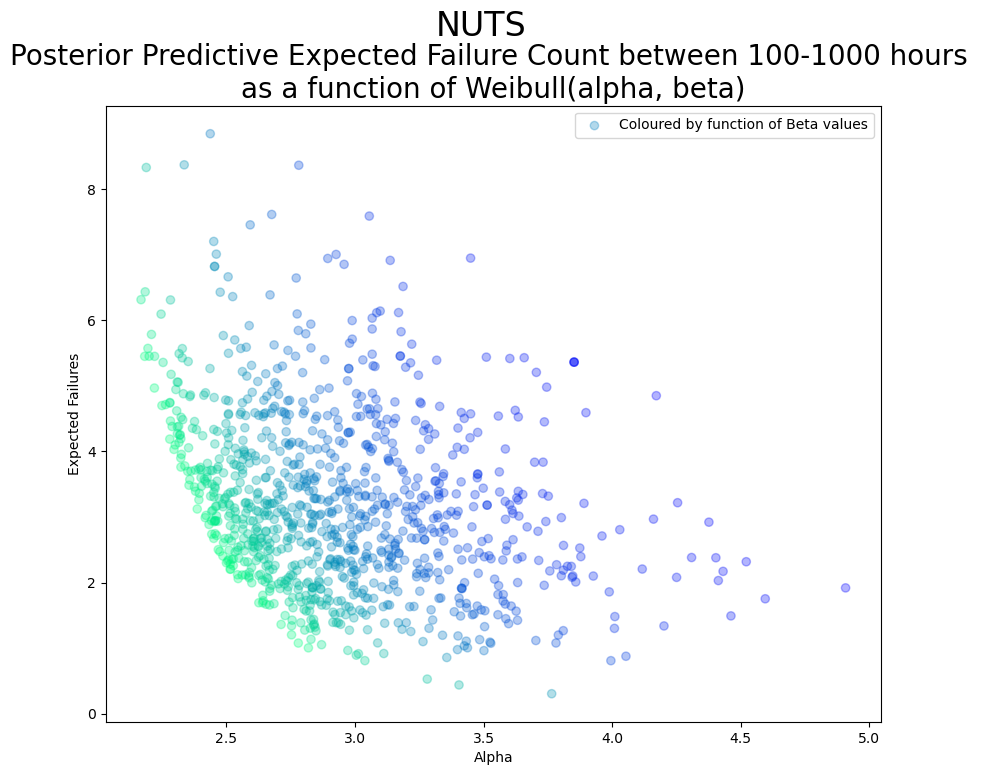

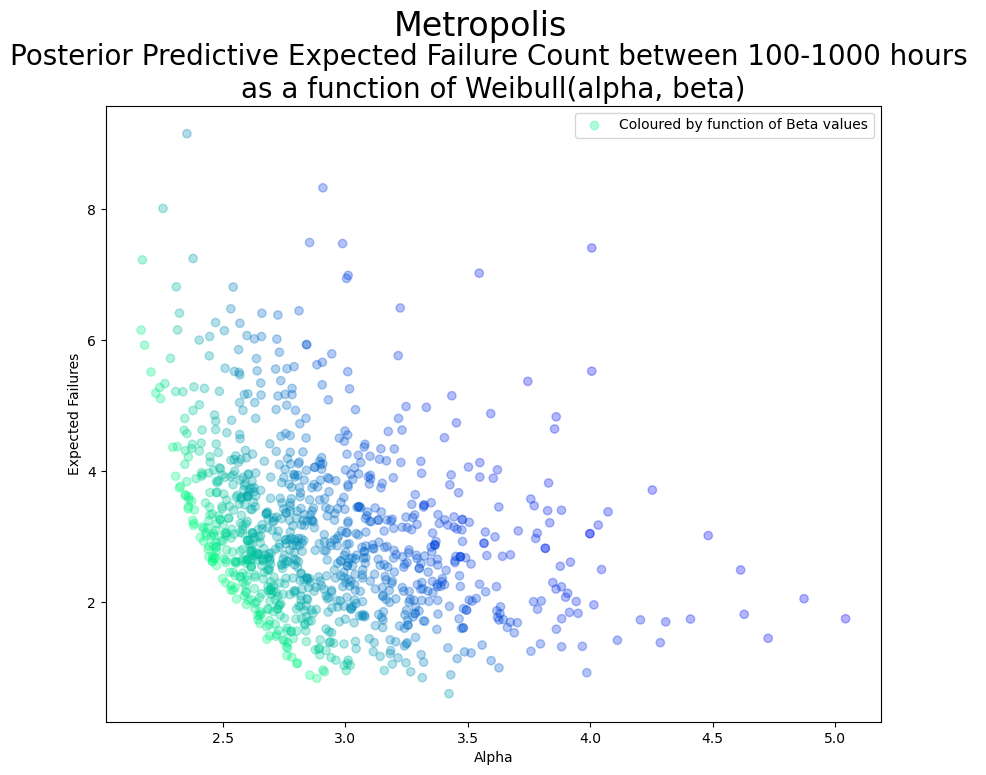

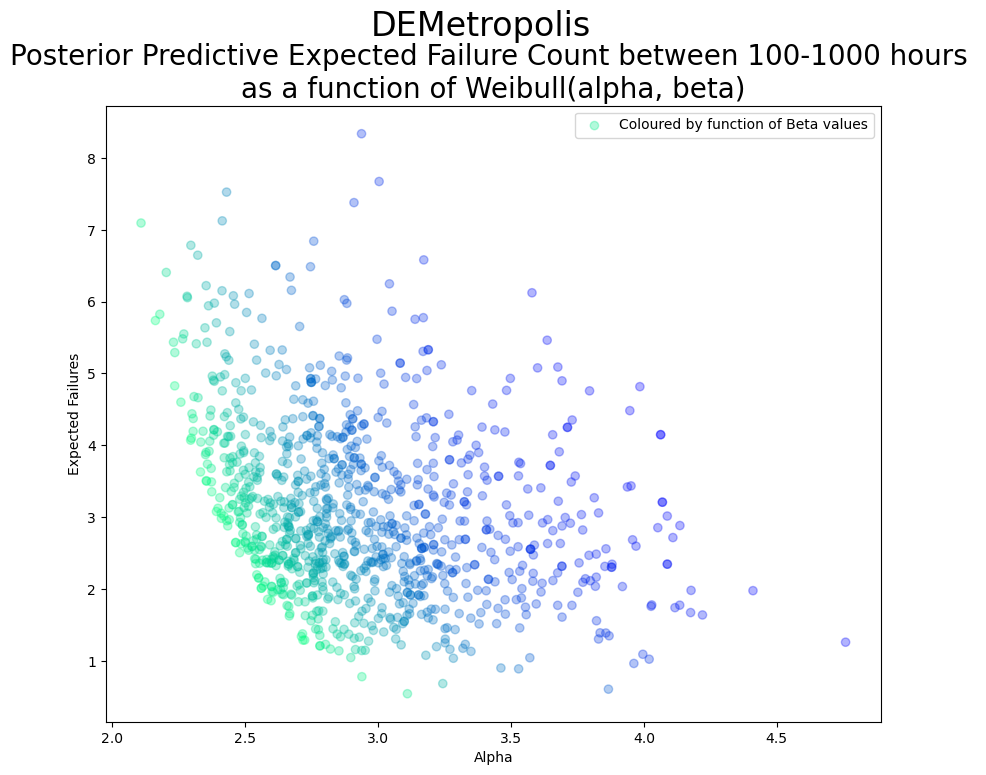

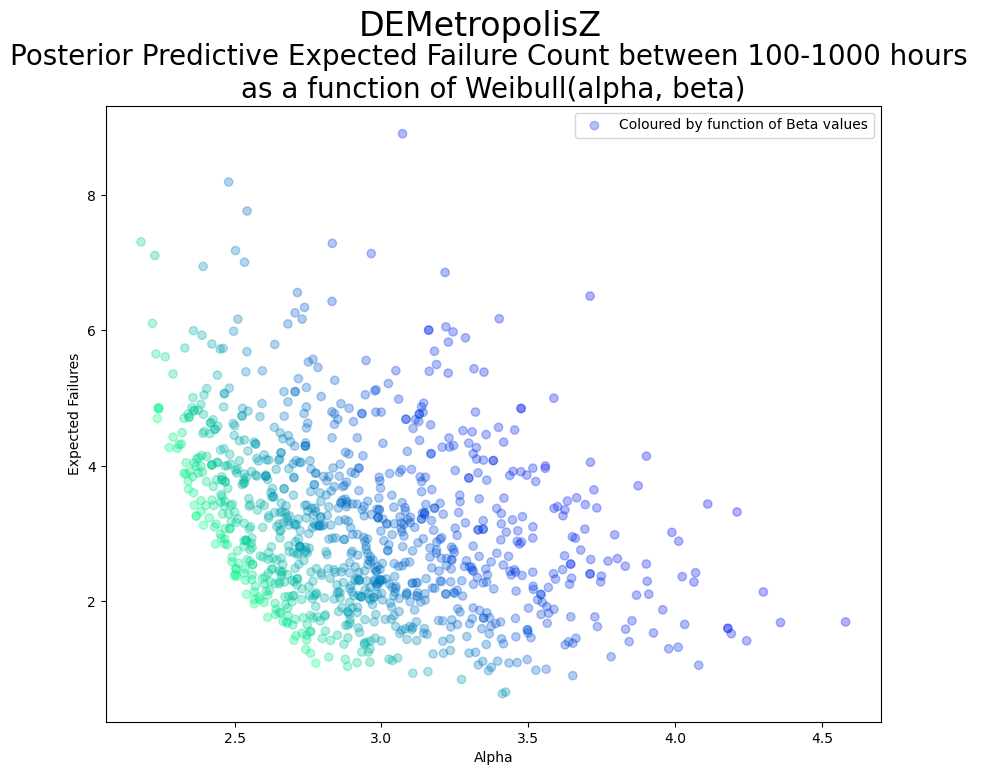

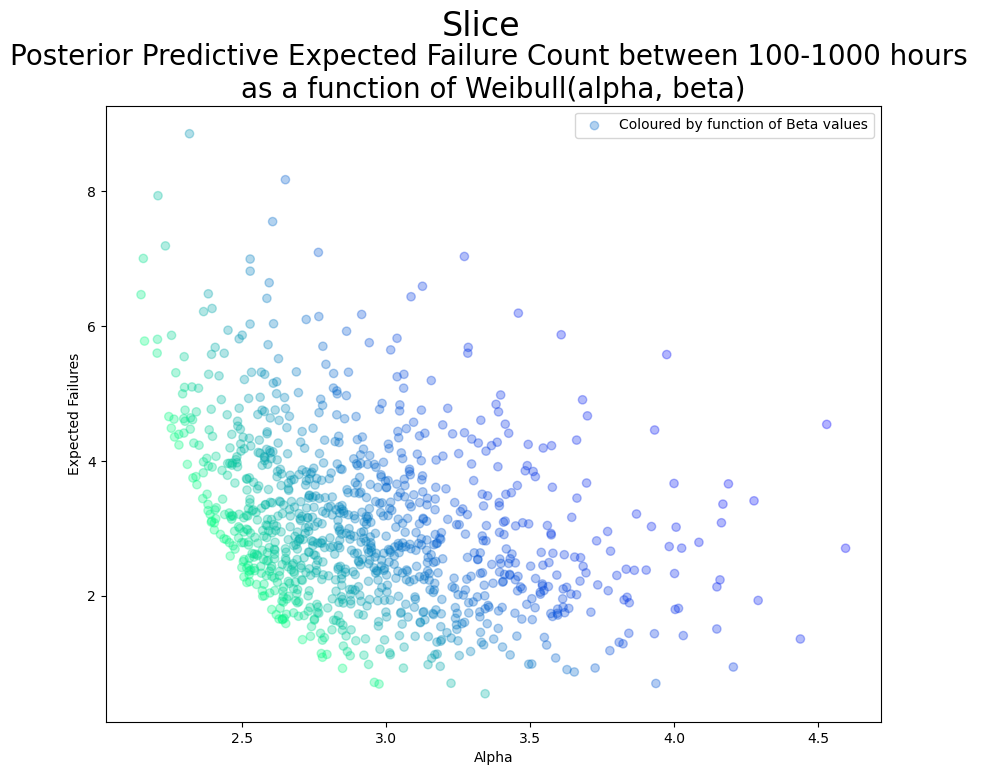

In [51]:
failfuncofweibull(joint_drawsN,output_dsN,"NUTS")
failfuncofweibull(joint_drawsM,output_dsM,"Metropolis")
failfuncofweibull(joint_drawsDEM,output_dsDEM,"DEMetropolis")
failfuncofweibull(joint_drawsDEMZ,output_dsDEMZ,"DEMetropolisZ")
failfuncofweibull(joint_drawsS,output_dsS,"Slice")

In [52]:
def uncertainty(output_ds,title):
    fig, ax1 = plt.subplots(figsize=(10, 8))

    ax1.hist(
        output_ds["expected"], ec="black", color="red", label="Expected Count of Failures", bins=20
    )
    ax1.axvline(output_ds["lb"].mean(), label="Expected 95% PI Lower Bound on Failure Count")
    ax1.axvline(output_ds["ub"].mean(), label="Expected 95% PI Upper Bound on Failure Count")
    ax1.set_title("Expected Failure Counts", fontsize=20)
    fig.suptitle(title, fontsize=24,y=1)
    ax1.set_xlabel("Expected Failures")
    ax1.set_ylabel("Time")
    ax1.legend()

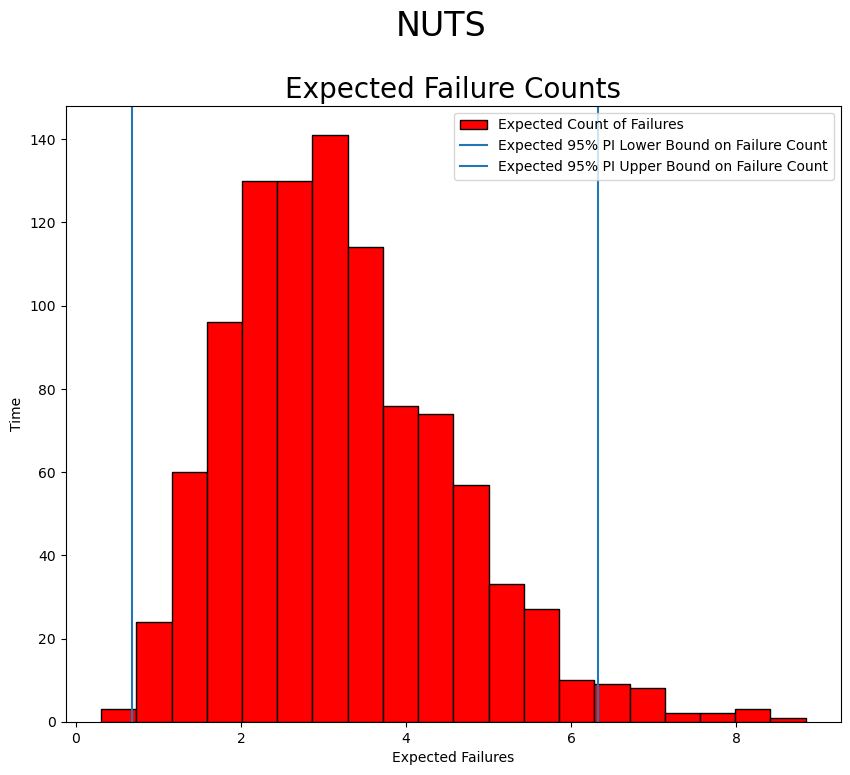

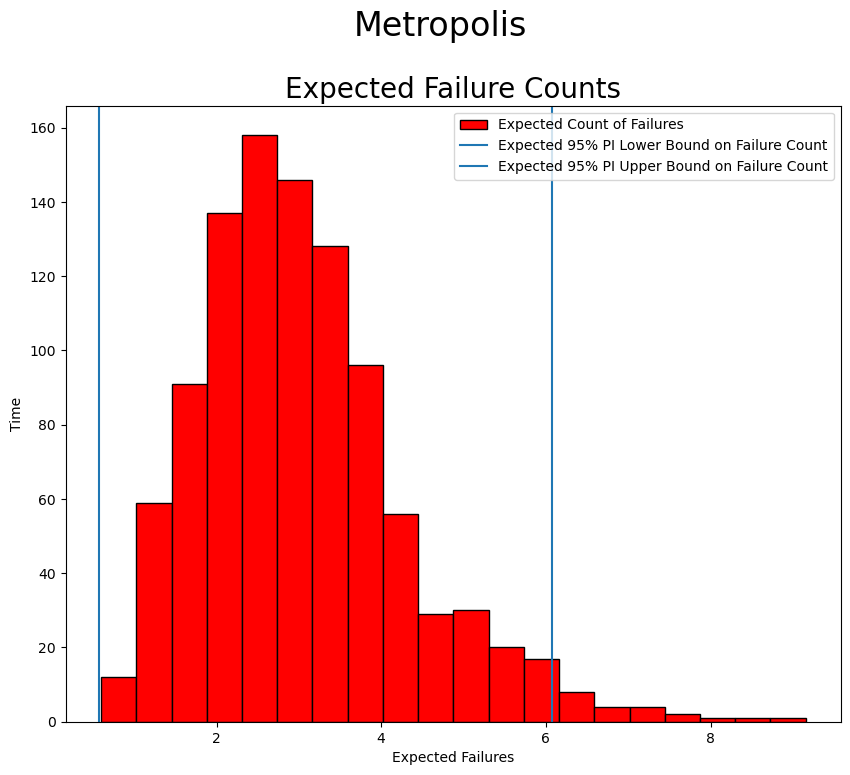

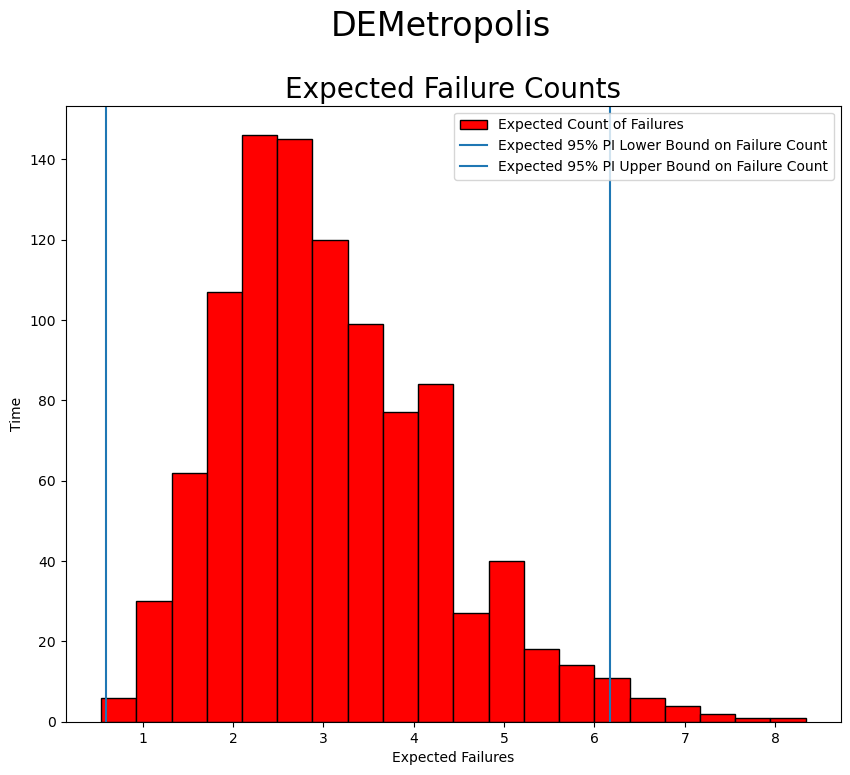

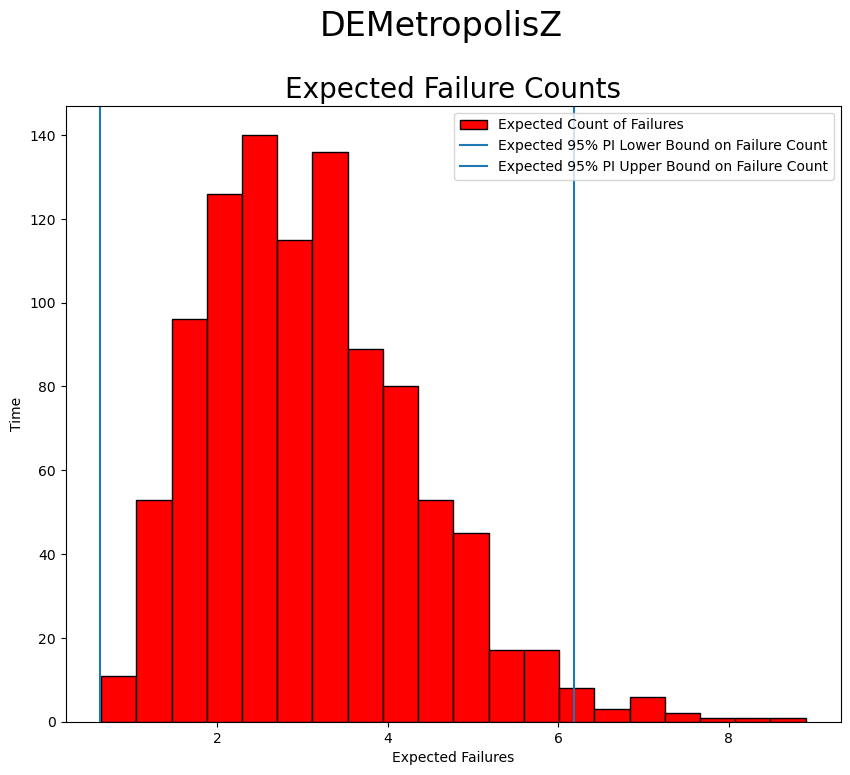

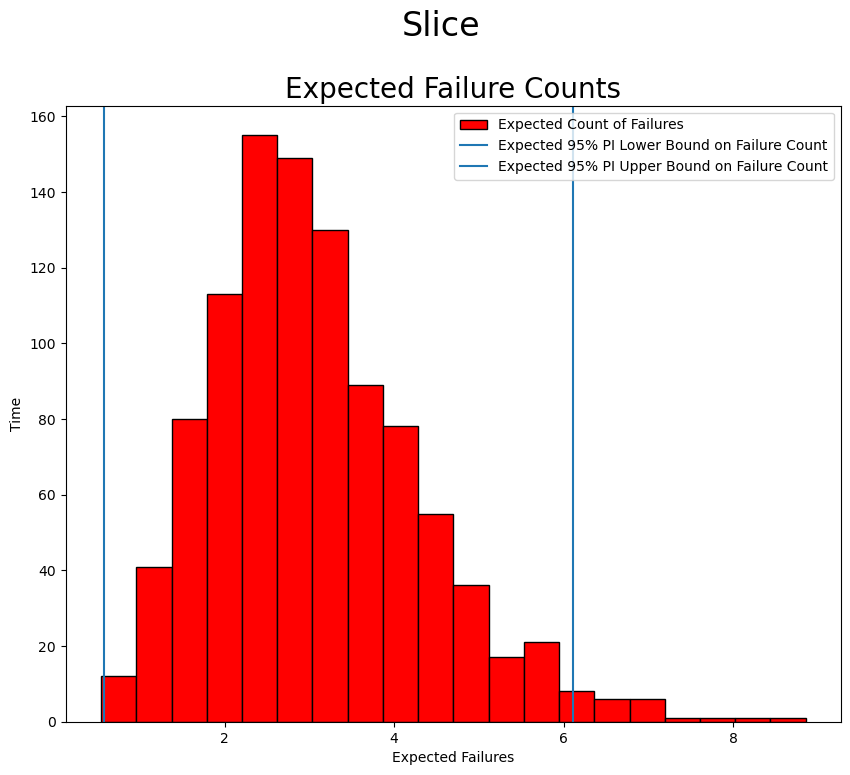

In [53]:
uncertainty(output_dsN,"NUTS")
uncertainty(output_dsM,"Metropolis")
uncertainty(output_dsDEM,"DEMetropolis")
uncertainty(output_dsDEMZ,"DEMetropolisZ")
uncertainty(output_dsS,"Slice")